In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 
import json
import math


In [2]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

In [3]:
# Import MDAnalysis
import MDAnalysis as mda
import statsmodels as stats
from MDAnalysis.analysis import polymer, distances, rdf
import matplotlib.font_manager as font_manager

In [4]:
from polymer_MD_analysis import pers_length, get_rg_pers_poly, bavg_pers_cnt

## PEG/dmso system analysis

### N = 6 PEG/DMSO 

In [5]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n6_peg_dmso = mda.Universe("n6peg_dmso/n6pegonly_dmso.pdb", "n6peg_dmso/nodmso_n6peg.xtc")

In [6]:
n6_peg_dmso.trajectory

<XTCReader n6peg_dmso/nodmso_n6peg.xtc with 18001 frames of 45 atoms>

In [7]:
len(n6_peg_dmso.trajectory)

18001

In [8]:
#Select the polymer heavy atoms 
peg_n6dmso = n6_peg_dmso.select_atoms("resname sPEG PEG tPEG and not type H")

In [9]:
crv_n6peg_dmso = pers_length(peg_n6dmso,6)
crv_n6peg_dmso

array([[ 1.        ,  0.99455581,  0.99062149,  0.98327341,  0.97002216],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ],
       [ 0.        ,  0.        ,  0.        , 10.49418094, 14.06464437]])

In [10]:
com_bond = np.zeros(shape=(1,18000))
count = 0
for ts in n6_peg_dmso.trajectory[0:18000]:
    n6_mon1_dmso = n6_peg_dmso.select_atoms("resid 1")
    n6_mon2_dmso = n6_peg_dmso.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n6_mon1_dmso.center_of_mass(), n6_mon2_dmso.center_of_mass(), 
                                                   box=n6_peg_dmso.trajectory.ts.dimensions)
    com_bond[0, count] = oo_len
    count += 1
    

In [11]:
com_bond

array([[3.53350002, 3.23345886, 3.20921526, ..., 3.25338305, 3.09876112,
        2.93677543]])

In [12]:
lb_avg_pn6 = np.mean(com_bond)
lb_avg_pn6

3.2419135998493824

In [13]:
np.std(com_bond)

0.18863018935460654

### Radius of Gyration vs. time N = 6 PEG/dmso

In [14]:
n6peg_rgens_dmso, cor_n6peg_dmso, N6peg_cos_dmso, rgdmso_n6peg = get_rg_pers_poly(peg_n6dmso, n6_peg_dmso, 0, 18000)

In [15]:
n6peg_rgens_dmso[0].shape

(18000,)

In [16]:
cor_n6peg_dmso[3]

array([0., 1., 2., 3., 4.])

In [17]:
N6peg_cos_dmso

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99455581, 0.97115107, 0.93912044, ..., 0.86360955, 0.86343516,
        0.81104202],
       [0.99062149, 0.94785464, 0.91981512, ..., 0.62919399, 0.60184819,
        0.4504974 ],
       [0.98327341, 0.9707317 , 0.92717501, ..., 0.54157293, 0.44880438,
        0.48221947],
       [0.97002216, 0.97358134, 0.85910879, ..., 0.10438749, 0.02226476,
        0.45941551]])

In [18]:
rgdmso_n6peg

4.454765844991922

In [19]:
np.std(n6peg_rgens_dmso)

0.6920312874966961

In [20]:
trj_len = np.arange(18000)

#trj_len += 1
trj_len


array([    0,     1,     2, ..., 17997, 17998, 17999])

(0.2, 2)

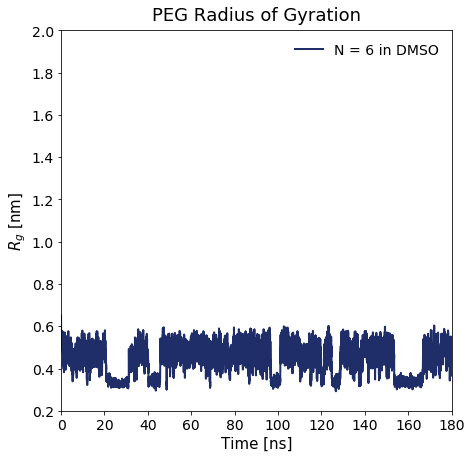

In [21]:
plt.figure(figsize=(7,7))
plt.title(r'PEG Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n6peg_rgens_dmso[0]/10,linewidth=2, color='#1F2E69')
plt.tick_params(labelsize=14)
plt.legend(['N = 6 in DMSO'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Correlation values at each arc length for the whole 180 ns trajectory, N = 6 PEG/dmso

In [23]:
# x values
blen_dmso = cor_n6peg_dmso[3]*lb_avg_pn6
#nt_tt[0] = 0
blen_dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544])

In [24]:
# Error prop. into natural log std deviation
mk_n6p_dmso = cor_n6peg_dmso[1]/cor_n6peg_dmso[0]
mk_n6p_dmso

array([5.58370933e-17, 5.08373831e-02, 1.77216880e-01, 4.33193206e-01,
       7.96488889e-01])

<ErrorbarContainer object of 3 artists>

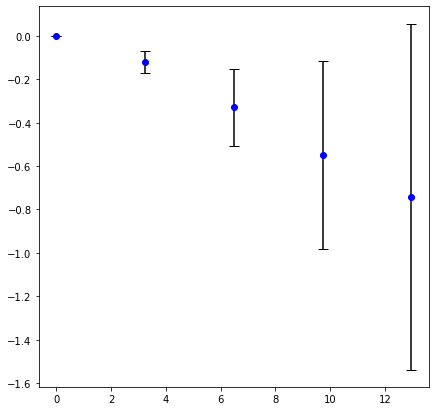

In [25]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_dmso, np.log(cor_n6peg_dmso[0]), yerr=mk_n6p_dmso, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [26]:
# All the points give the best fits for N = 6 peg in water
n6_blkspeg_dmso , n6peg_lpdmso = bavg_pers_cnt(5, peg_n6dmso, n6_peg_dmso, lb_avg_pn6, 5, 3000 , 18000)

3000
6000
Lp [Angstroms]: 16.809450819424047
Error in Lp from fit [Angstroms], 95% CL: 3.3301372387120307
R2 score: 0.9785260835461235
6000
9000
Lp [Angstroms]: 25.078841659093637
Error in Lp from fit [Angstroms], 95% CL: 2.1789494274728463
R2 score: 0.9953958918000745
9000
12000
Lp [Angstroms]: 18.201036466028352
Error in Lp from fit [Angstroms], 95% CL: 3.147792972890552
R2 score: 0.9832619440217341
12000
15000
Lp [Angstroms]: 19.792809366209973
Error in Lp from fit [Angstroms], 95% CL: 2.6950216682579993
R2 score: 0.9892081129886878
15000
18000
Lp [Angstroms]: 14.283992614209334
Error in Lp from fit [Angstroms], 95% CL: 2.7294267323481027
R2 score: 0.9798081995032031


In [27]:
n6_blkspeg_dmso

{'Avg Radius of gyration': array([4.44895948, 4.74870206, 4.53469101, 4.53193381, 4.16387863]),
 'Avg persistence length': array([16.80945082, 25.07884166, 18.20103647, 19.79280937, 14.28399261])}

In [28]:
n6peg_lpdmso

array([[ 1.68094508e+01,  2.50788417e+01,  1.82010365e+01,
         1.97928094e+01,  1.42839926e+01],
       [ 3.33013724e+00,  2.17894943e+00,  3.14779297e+00,
         2.69502167e+00,  2.72942673e+00],
       [-5.94903433e-02, -3.98742499e-02, -5.49419261e-02,
        -5.05233988e-02, -7.00084372e-02],
       [ 1.89380323e-03,  1.63639859e-04,  1.23098436e-03,
         6.45237271e-04,  2.43988358e-03]])

In [29]:
n6peg_lpdmso[2]

array([-0.05949034, -0.03987425, -0.05494193, -0.0505234 , -0.07000844])

In [30]:
np.mean(n6peg_lpdmso[3])

0.001274709660029268

In [31]:
def line_fit(slope, x):
    return slope*x 

In [32]:
blen_dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544])

In [33]:
gg_n6peg_dmso = line_fit(np.mean(n6peg_lpdmso[2]),blen_dmso)

In [34]:
gg_n6peg_dmso

array([-0.        , -0.17820044, -0.35640088, -0.53460132, -0.71280176])

### Block averaged Radius of gyration and persistence length, N = 6 PEG/DMSO

In [35]:
np.mean(n6_blkspeg_dmso["Avg persistence length"])

18.83322618499307

In [36]:
np.std(n6_blkspeg_dmso["Avg persistence length"])

3.6088604623784852

In [37]:
np.mean(n6_blkspeg_dmso["Avg Radius of gyration"])

4.485632995739893

In [38]:
np.std(n6_blkspeg_dmso["Avg Radius of gyration"])

0.18901143044339638

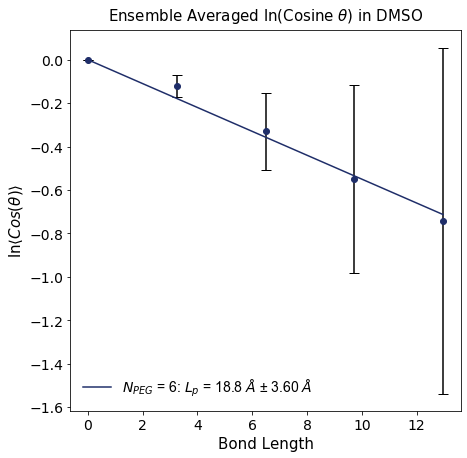

In [45]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_dmso, np.log(cor_n6peg_dmso[0]), yerr=mk_n6p_dmso, color='#1F2E69', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen_dmso, gg_n6peg_dmso, color='#1F2E69')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in DMSO', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.legend([r'$N_{PEG}$ = 6: $L_{p}$ = 18.8 $\AA$ ± 3.60 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
#plt.text(0.5, -6.94,r'$N_{PEG}$ = 6: $L_{p}$ = 18.8 $\AA$ ± 3.61 $\AA$', fontsize=15, color='#1F2E69')

In [43]:
rgpeg_olig_dmso =  pd.DataFrame(data=n6_blkspeg_dmso["Avg Radius of gyration"], columns=['$R_{g}$ [Angstrom] N = 6 PEG DMSO'])
rgpeg_olig_dmso

,$R_{g}$ [Angstrom] N = 6 PEG DMSO
0,4.448959
1,4.748702
2,4.534691
3,4.531934
4,4.163879


In [44]:
pers_pegt_dmso = pd.DataFrame(data=n6_blkspeg_dmso["Avg persistence length"], columns=[r"$L_{p}$ [Angstrom] N = 6 PEG DMSO "])
pers_pegt_dmso

,$L_{p}$ [Angstrom] N = 6 PEG DMSO
0,16.809451
1,25.078842
2,18.201036
3,19.792809
4,14.283993


### N = 8 PEG/DMSO 

In [46]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n8_peg_dmso = mda.Universe("n8peg_dmso/n8pegonly_dmso.pdb", "n8peg_dmso/nodmso_n8peg.xtc")

In [47]:
n8_peg_dmso.trajectory

<XTCReader n8peg_dmso/nodmso_n8peg.xtc with 18001 frames of 59 atoms>

In [48]:
len(n8_peg_dmso.trajectory)

18001

In [49]:
#Select the polymer heavy atoms 
peg_n8dmso = n8_peg_dmso.select_atoms("resname sPEG PEG tPEG and not type H")

In [50]:
crv_n8peg_dmso = pers_length(peg_n8dmso,8)
crv_n8peg_dmso

array([[1.        , 0.98841966, 0.99062982, 0.99294482, 0.9915651 ,
        0.98732389, 0.9929842 ],
       [0.        , 1.        , 2.        , 3.        , 4.        ,
        5.        , 6.        ],
       [0.        , 8.72806975, 0.        , 0.        , 0.        ,
        9.13251628, 0.        ]])

In [51]:
com_bond_n8dmso = np.zeros(shape=(1,18000))
count = 0
for ts in n8_peg_dmso.trajectory[0:18000]:
    n8_mon1_dmso = n8_peg_dmso.select_atoms("resid 1")
    n8_mon2_dmso = n8_peg_dmso.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n8_mon1_dmso.center_of_mass(), n8_mon2_dmso.center_of_mass(), 
                                                   box=n8_peg_dmso.trajectory.ts.dimensions)
    com_bond_n8dmso[0, count] = oo_len
    count += 1
    

In [52]:
com_bond

array([[3.53350002, 3.23345886, 3.20921526, ..., 3.25338305, 3.09876112,
        2.93677543]])

In [53]:
lb_avg_pn6

3.2419135998493824

In [54]:
np.std(com_bond)

0.18863018935460654

In [55]:
np.mean(com_bond_n8dmso)

3.2224598658499217

In [56]:
np.std(com_bond_n8dmso)

0.19897830735152627

### Radius of Gyration vs. time N = 8 PEG/dmso

In [57]:
n8peg_rgens_dmso, cor_n8peg_dmso, N8peg_cos_dmso, rgdmso_n8peg = get_rg_pers_poly(peg_n8dmso, n8_peg_dmso, 0, 18000)

In [58]:
n8peg_rgens_dmso[0].shape

(18000,)

In [59]:
cor_n8peg_dmso[3]

array([0., 1., 2., 3., 4., 5., 6.])

In [60]:
N8peg_cos_dmso

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.98841966,  0.95563446,  0.95306746, ...,  0.90839921,
         0.9097052 ,  0.92673922],
       [ 0.99062982,  0.9384285 ,  0.90754751, ...,  0.75657226,
         0.7876528 ,  0.73377683],
       ...,
       [ 0.9915651 ,  0.89552446,  0.91963313, ...,  0.39868129,
         0.33030656,  0.27731802],
       [ 0.98732389,  0.86117277,  0.83170942, ...,  0.06841671,
         0.09591484,  0.1113029 ],
       [ 0.9929842 ,  0.85704069,  0.6531179 , ..., -0.12128953,
         0.10163987,  0.26323291]])

In [61]:
rgdmso_n8peg

5.595146806289504

In [62]:
np.std(n8peg_rgens_dmso)

0.8306614408196168

In [63]:
trj_len = np.arange(18000)

#trj_len += 1
trj_len


array([    0,     1,     2, ..., 17997, 17998, 17999])

(0.2, 2)

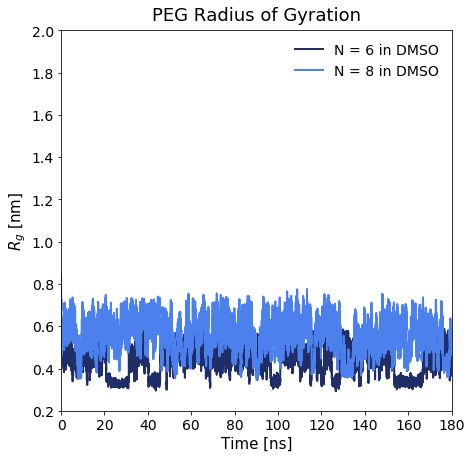

In [64]:
plt.figure(figsize=(7,7))
plt.title(r'PEG Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n6peg_rgens_dmso[0]/10,linewidth=2, color='#1F2E69')
plt.plot(trj_len/100, n8peg_rgens_dmso[0]/10,linewidth=2, color='#4C80ED')
plt.tick_params(labelsize=14)
plt.legend(['N = 6 in DMSO','N = 8 in DMSO'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Correlation values at each arc length for the whole 180 ns trajectory, N = 8 PEG/dmso

In [65]:
# x values
blen_n8dmso = cor_n8peg_dmso[3]*lb_avg_pn6
#nt_tt[0] = 0
blen_n8dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544,
       16.209568 , 19.4514816])

In [66]:
# Error prop. into natural log std deviation
mk_n8p_dmso = cor_n8peg_dmso[1]/cor_n8peg_dmso[0]
mk_n8p_dmso

array([3.73756764e-17, 3.23613852e-02, 1.15320056e-01, 2.55389065e-01,
       4.55853481e-01, 7.14489633e-01, 1.04887378e+00])

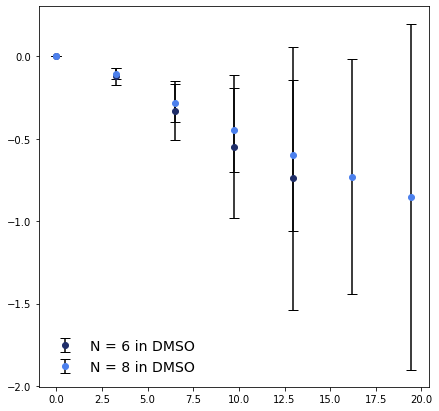

In [85]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_dmso, np.log(cor_n6peg_dmso[0]), yerr=mk_n6p_dmso, color='#1F2E69', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8dmso, np.log(cor_n8peg_dmso[0]), yerr=mk_n8p_dmso, color='#4C80ED', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.legend(['N = 6 in DMSO','N = 8 in DMSO'], frameon=False, fontsize=14)

In [68]:
# All the points give the best fits for N = 6 peg in water
n8_blkspeg_dmso , n8peg_lpdmso = bavg_pers_cnt(5, peg_n8dmso, n8_peg_dmso, lb_avg_pn6, 5, 3000 , 18000)

3000
6000
Lp [Angstroms]: 24.031715816800098
Error in Lp from fit [Angstroms], 95% CL : 1.3514244964624402
R2 score: 0.9934164600662859
6000
9000
Lp [Angstroms]: 24.51684858662788
Error in Lp from fit [Angstroms], 95% CL : 1.2257993486178242
R2 score: 0.9946972792177611
9000
12000
Lp [Angstroms]: 23.768712419858353
Error in Lp from fit [Angstroms], 95% CL : 1.6733504893296405
R2 score: 0.9891790841101049
12000
15000
Lp [Angstroms]: 18.25658600869716
Error in Lp from fit [Angstroms], 95% CL : 2.0566628314371584
R2 score: 0.975946409087187
15000
18000
Lp [Angstroms]: 20.10864274157849
Error in Lp from fit [Angstroms], 95% CL : 1.9596841593406975
R2 score: 0.9815079607707535


In [69]:
n8_blkspeg_dmso

{'Avg Radius of gyration': array([5.71962342, 5.76105666, 5.67201023, 5.29693542, 5.45163437]),
 'Avg persistence length': array([24.03171582, 24.51684859, 23.76871242, 18.25658601, 20.10864274])}

In [70]:
n8peg_lpdmso

array([[ 2.40317158e+01,  2.45168486e+01,  2.37687124e+01,
         1.82565860e+01,  2.01086427e+01],
       [ 1.35142450e+00,  1.22579935e+00,  1.67335049e+00,
         2.05666283e+00,  1.95968416e+00],
       [-4.16116772e-02, -4.07882765e-02, -4.20721149e-02,
        -5.47747536e-02, -4.97298606e-02],
       [ 2.61298664e-04,  1.98459973e-04,  4.18643103e-04,
         1.81694032e-03,  1.12081482e-03]])

In [71]:
n8peg_lpdmso[2]

array([-0.04161168, -0.04078828, -0.04207211, -0.05477475, -0.04972986])

In [72]:
np.mean(n8peg_lpdmso[3])

0.000763231377073506

In [73]:
blen_dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544])

In [74]:
blen_n8dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544,
       16.209568 , 19.4514816])

In [75]:
gg_n8peg_dmso = line_fit(np.mean(n8peg_lpdmso[2]),blen_n8dmso)

In [76]:
gg_n6peg_n8dmso = line_fit(np.mean(n6peg_lpdmso[2]),blen_n8dmso)

In [77]:
gg_n8peg_dmso

array([-0.        , -0.14846452, -0.29692905, -0.44539357, -0.5938581 ,
       -0.74232262, -0.89078715])

### Block averaged Radius of gyration and persistence length, N = 8 PEG/DMSO

In [78]:
np.mean(n8_blkspeg_dmso["Avg persistence length"])

22.136501114712395

In [79]:
np.std(n8_blkspeg_dmso["Avg persistence length"])

2.493509872051226

In [80]:
np.mean(n8_blkspeg_dmso["Avg Radius of gyration"])

5.580252023192735

In [81]:
np.std(n8_blkspeg_dmso["Avg Radius of gyration"])

0.17739507932156937

Text(0.5, -5.58, '$N_{PEG}$ = 8: $L_{p}$ = 22.1 $\\AA$ ± 2.49 $\\AA$')

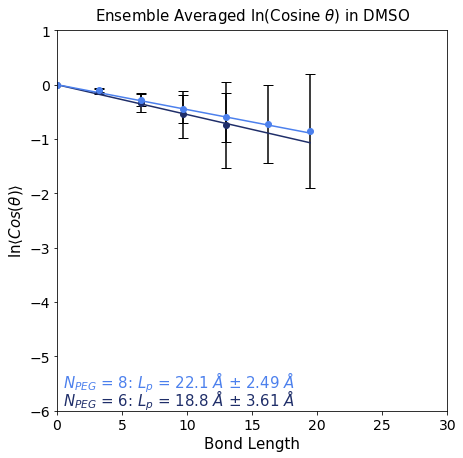

In [84]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_dmso, np.log(cor_n6peg_dmso[0]), yerr=mk_n6p_dmso, color='#1F2E69', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8dmso, np.log(cor_n8peg_dmso[0]), yerr=mk_n8p_dmso, color='#4C80ED', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen_n8dmso, gg_n6peg_n8dmso, color='#1F2E69')
plt.plot(blen_n8dmso, gg_n8peg_dmso, color='#4C80ED')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in DMSO', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.ylim(-6,1)
plt.xlim(0,30)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
#plt.legend([r'$N_{PEG}$ = 6: $L_{p}$ = 18.8 $\AA$ ± 3.60 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(0.5, -5.9,r'$N_{PEG}$ = 6: $L_{p}$ = 18.8 $\AA$ ± 3.61 $\AA$', fontsize=15, color='#1F2E69')
plt.text(0.5, -5.58,r'$N_{PEG}$ = 8: $L_{p}$ = 22.1 $\AA$ ± 2.49 $\AA$', fontsize=15, color='#4C80ED')

In [86]:
rgpeg_olig_dmso[r"$R_{g}$ [Angstrom] N = 8 PEG DMSO "] = n8_blkspeg_dmso["Avg Radius of gyration"]
rgpeg_olig_dmso

,$R_{g}$ [Angstrom] N = 6 PEG DMSO,$R_{g}$ [Angstrom] N = 8 PEG DMSO
0,4.448959,5.719623
1,4.748702,5.761057
2,4.534691,5.672010
3,4.531934,5.296935
4,4.163879,5.451634


In [87]:
pers_pegt_dmso[r"$L_{p}$ [Angstrom] N = 8 PEG DMSO "] = n8_blkspeg_dmso["Avg persistence length"]
pers_pegt_dmso

,$L_{p}$ [Angstrom] N = 6 PEG DMSO,$L_{p}$ [Angstrom] N = 8 PEG DMSO
0,16.809451,24.031716
1,25.078842,24.516849
2,18.201036,23.768712
3,19.792809,18.256586
4,14.283993,20.108643


### N = 10 PEG/DMSO 

In [88]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n10_peg_dmso = mda.Universe("n10peg_dmso/n10pegonly_dmso.pdb", "n10peg_dmso/nodmso_n10peg.xtc")

In [89]:
n10_peg_dmso.trajectory

<XTCReader n10peg_dmso/nodmso_n10peg.xtc with 18001 frames of 73 atoms>

In [90]:
len(n10_peg_dmso.trajectory)

18001

In [91]:
#Select the polymer heavy atoms 
peg_n10dmso = n10_peg_dmso.select_atoms("resname sPEG PEG tPEG and not type H")

In [92]:
crv_n10peg_dmso = pers_length(peg_n10dmso,10)
crv_n10peg_dmso

array([[ 1.        ,  0.99450179,  0.99310337,  0.99145182,  0.99249793,
         0.9909167 ,  0.98960715,  0.98480319,  0.97639044],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  8.26764357, 10.00150397, 12.47497656]])

In [93]:
com_bond_n10dmso = np.zeros(shape=(1,18000))
count = 0
for ts in n10_peg_dmso.trajectory[0:18000]:
    n10_mon1_dmso = n10_peg_dmso.select_atoms("resid 1")
    n10_mon2_dmso = n10_peg_dmso.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n10_mon1_dmso.center_of_mass(), n10_mon2_dmso.center_of_mass(), 
                                                   box=n10_peg_dmso.trajectory.ts.dimensions)
    com_bond_n10dmso[0, count] = oo_len
    count += 1
    

In [94]:
com_bond

array([[3.53350002, 3.23345886, 3.20921526, ..., 3.25338305, 3.09876112,
        2.93677543]])

In [95]:
lb_avg_pn6

3.2419135998493824

In [96]:
np.std(com_bond)

0.18863018935460654

In [97]:
np.mean(com_bond_n10dmso)

3.2203354186874407

In [98]:
np.std(com_bond_n10dmso)

0.20255855226182926

### Radius of Gyration vs. time N = 10 PEG/dmso

In [99]:
n10peg_rgens_dmso, cor_n10peg_dmso, N10peg_cos_dmso, rgdmso_n10peg = get_rg_pers_poly(peg_n10dmso, n10_peg_dmso, 0, 18000)

In [100]:
n10peg_rgens_dmso[0].shape

(18000,)

In [101]:
cor_n10peg_dmso[3]

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [102]:
N10peg_cos_dmso

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.99450179,  0.9725006 ,  0.92948234, ...,  0.90814824,
         0.90641534,  0.92048769],
       [ 0.99310337,  0.94376299,  0.92369561, ...,  0.78068231,
         0.74463387,  0.75337306],
       ...,
       [ 0.98960715,  0.91421632,  0.87055635, ...,  0.33577068,
         0.32344981,  0.34654812],
       [ 0.98480319,  0.89820696,  0.83115209, ...,  0.08258712,
         0.0723968 ,  0.11718237],
       [ 0.97639044,  0.81581777,  0.67856416, ..., -0.11676874,
        -0.14874379, -0.194499  ]])

In [103]:
rgdmso_n10peg

6.361194373132558

In [104]:
np.std(n10peg_rgens_dmso)

1.1144481201245717

In [105]:
trj_len = np.arange(18000)

#trj_len += 1
trj_len


array([    0,     1,     2, ..., 17997, 17998, 17999])

(0.2, 2)

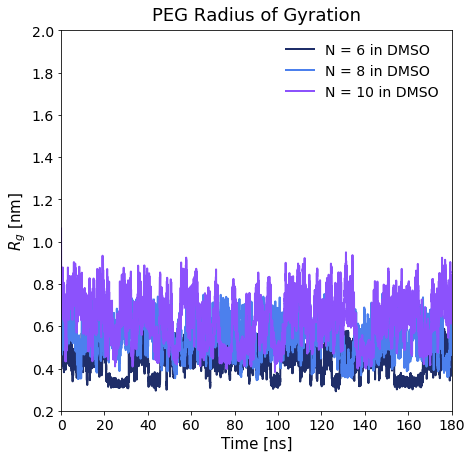

In [106]:
plt.figure(figsize=(7,7))
plt.title(r'PEG Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n6peg_rgens_dmso[0]/10,linewidth=2, color='#1F2E69')
plt.plot(trj_len/100, n8peg_rgens_dmso[0]/10,linewidth=2, color='#4C80ED')
plt.plot(trj_len/100, n10peg_rgens_dmso[0]/10,linewidth=2, color='#8C52FC')
plt.tick_params(labelsize=14)
plt.legend(['N = 6 in DMSO','N = 8 in DMSO','N = 10 in DMSO' ], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Correlation values at each arc length for the whole 180 ns trajectory, N = 8 PEG/dmso

In [107]:
# x values
blen_n10dmso = cor_n10peg_dmso[3]*lb_avg_pn6
#nt_tt[0] = 0
blen_n10dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544,
       16.209568 , 19.4514816, 22.6933952, 25.9353088])

In [108]:
# Error prop. into natural log std deviation
mk_n10p_dmso = cor_n10peg_dmso[1]/cor_n10peg_dmso[0]
mk_n10p_dmso

array([3.72288166e-17, 2.66995294e-02, 9.01213783e-02, 2.05888877e-01,
       3.66287178e-01, 5.85464233e-01, 8.45676660e-01, 1.16383142e+00,
       1.55561678e+00])

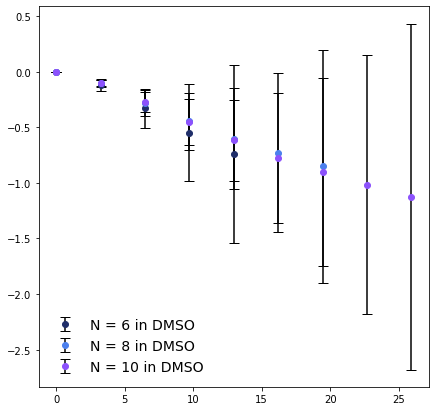

In [109]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_dmso, np.log(cor_n6peg_dmso[0]), yerr=mk_n6p_dmso, color='#1F2E69', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8dmso, np.log(cor_n8peg_dmso[0]), yerr=mk_n8p_dmso, color='#4C80ED', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10dmso, np.log(cor_n10peg_dmso[0]), yerr=mk_n10p_dmso, color='#8C52FC', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.legend(['N = 6 in DMSO','N = 8 in DMSO','N = 10 in DMSO'], frameon=False, fontsize=14)

In [110]:
# All the points give the best fits for N = 6 peg in water
n10_blkspeg_dmso , n10peg_lpdmso = bavg_pers_cnt(5, peg_n10dmso, n10_peg_dmso, lb_avg_pn6, 5, 3000 , 18000)

3000
6000
Lp [Angstroms]: 22.492805070690395
Error in Lp from fit [Angstroms], 95% CL : 0.9369237622243255
R2 score: 0.9903058695102129
6000
9000
Lp [Angstroms]: 17.20932821500442
Error in Lp from fit [Angstroms], 95% CL : 1.3782286452084431
R2 score: 0.9676288904559768
9000
12000
Lp [Angstroms]: 21.63668598824028
Error in Lp from fit [Angstroms], 95% CL : 1.1976854345171484
R2 score: 0.9835325679873382
12000
15000
Lp [Angstroms]: 20.51880811070344
Error in Lp from fit [Angstroms], 95% CL : 1.0029317588699187
R2 score: 0.9869271194673283
15000
18000
Lp [Angstroms]: 24.10767645095798
Error in Lp from fit [Angstroms], 95% CL : 0.8469632408791449
R2 score: 0.9929865424799854


In [111]:
n10_blkspeg_dmso

{'Avg Radius of gyration': array([6.41389651, 5.74091517, 6.42018628, 6.20663886, 6.60014126]),
 'Avg persistence length': array([22.49280507, 17.20932822, 21.63668599, 20.51880811, 24.10767645])}

In [112]:
n10peg_lpdmso

array([[ 2.24928051e+01,  1.72093282e+01,  2.16366860e+01,
         2.05188081e+01,  2.41076765e+01],
       [ 9.36923762e-01,  1.37822865e+00,  1.19768543e+00,
         1.00293176e+00,  8.46963241e-01],
       [-4.44586612e-02, -5.81080207e-02, -4.62177988e-02,
        -4.87357743e-02, -4.14805633e-02],
       [ 4.48879686e-04,  2.83454135e-03,  8.56679728e-04,
         7.42728640e-04,  2.77973650e-04]])

In [113]:
n10peg_lpdmso[2]

array([-0.04445866, -0.05810802, -0.0462178 , -0.04873577, -0.04148056])

In [114]:
np.mean(n10peg_lpdmso[3])

0.001032160611868984

In [115]:
blen_dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544])

In [116]:
blen_n10dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544,
       16.209568 , 19.4514816, 22.6933952, 25.9353088])

In [117]:
gg_n10peg_dmso = line_fit(np.mean(n10peg_lpdmso[2]),blen_n10dmso)

In [118]:
gg_n6peg_n10dmso = line_fit(np.mean(n6peg_lpdmso[2]),blen_n10dmso)

In [119]:
gg_n8peg_n10dmso = line_fit(np.mean(n8peg_lpdmso[2]),blen_n10dmso)

In [120]:
gg_n10peg_dmso

array([-0.        , -0.154964  , -0.309928  , -0.464892  , -0.619856  ,
       -0.77482   , -0.929784  , -1.084748  , -1.23971201])

### Block averaged Radius of gyration and persistence length, N = 10 PEG/DMSO

In [121]:
np.mean(n10_blkspeg_dmso["Avg persistence length"])

21.193060767119302

In [122]:
np.std(n10_blkspeg_dmso["Avg persistence length"])

2.3110977853575196

In [123]:
np.mean(n10_blkspeg_dmso["Avg Radius of gyration"])

6.2763556131079365

In [124]:
np.std(n10_blkspeg_dmso["Avg Radius of gyration"])

0.29529605301921663

Text(0.5, -5.23, '$N_{PEG}$ = 10: $L_{p}$ = 21.2 $\\AA$ ± 2.31 $\\AA$')

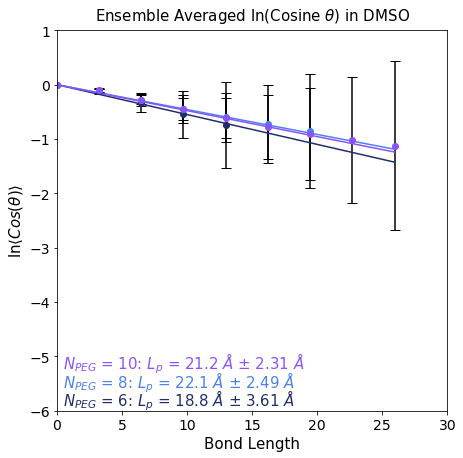

In [129]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_dmso, np.log(cor_n6peg_dmso[0]), yerr=mk_n6p_dmso, color='#1F2E69', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8dmso, np.log(cor_n8peg_dmso[0]), yerr=mk_n8p_dmso, color='#4C80ED', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10dmso, np.log(cor_n10peg_dmso[0]), yerr=mk_n10p_dmso, color='#8C52FC', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen_n10dmso, gg_n6peg_n10dmso, color='#1F2E69')
plt.plot(blen_n10dmso, gg_n8peg_n10dmso, color='#4C80ED')
plt.plot(blen_n10dmso, gg_n10peg_dmso, color='#8C52FC')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in DMSO', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.ylim(-6,1)
plt.xlim(0,30)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
#plt.legend([r'$N_{PEG}$ = 6: $L_{p}$ = 18.8 $\AA$ ± 3.60 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(0.5, -5.9,r'$N_{PEG}$ = 6: $L_{p}$ = 18.8 $\AA$ ± 3.61 $\AA$', fontsize=15, color='#1F2E69')
plt.text(0.5, -5.58,r'$N_{PEG}$ = 8: $L_{p}$ = 22.1 $\AA$ ± 2.49 $\AA$', fontsize=15, color='#4C80ED')
plt.text(0.5, -5.23,r'$N_{PEG}$ = 10: $L_{p}$ = 21.2 $\AA$ ± 2.31 $\AA$', fontsize=15, color='#8C52FC')

In [125]:
rgpeg_olig_dmso[r"$R_{g}$ [Angstrom] N = 10 PEG DMSO "] = n10_blkspeg_dmso["Avg Radius of gyration"]
rgpeg_olig_dmso

,$R_{g}$ [Angstrom] N = 6 PEG DMSO,$R_{g}$ [Angstrom] N = 8 PEG DMSO,$R_{g}$ [Angstrom] N = 10 PEG DMSO
0,4.448959,5.719623,6.413897
1,4.748702,5.761057,5.740915
2,4.534691,5.672010,6.420186
3,4.531934,5.296935,6.206639
4,4.163879,5.451634,6.600141


In [126]:
pers_pegt_dmso[r"$L_{p}$ [Angstrom] N = 10 PEG DMSO "] = n10_blkspeg_dmso["Avg persistence length"]
pers_pegt_dmso

,$L_{p}$ [Angstrom] N = 6 PEG DMSO,$L_{p}$ [Angstrom] N = 8 PEG DMSO,$L_{p}$ [Angstrom] N = 10 PEG DMSO
0,16.809451,24.031716,22.492805
1,25.078842,24.516849,17.209328
2,18.201036,23.768712,21.636686
3,19.792809,18.256586,20.518808
4,14.283993,20.108643,24.107676


### N = 20 PEG/DMSO 

In [130]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n20_peg_dmso = mda.Universe("n20peg_dmso/n20pegonly_dmso.pdb", "n20peg_dmso/nodmso_n20peg.xtc")

In [131]:
n20_peg_dmso.trajectory

<XTCReader n20peg_dmso/nodmso_n20peg.xtc with 18001 frames of 143 atoms>

In [132]:
len(n20_peg_dmso.trajectory)

18001

In [133]:
#Select the polymer heavy atoms 
peg_n20dmso = n20_peg_dmso.select_atoms("resname sPEG PEG tPEG and not type H")

In [134]:
crv_n20peg_dmso = pers_length(peg_n20dmso,20)
crv_n20peg_dmso

array([[ 1.        ,  0.9909404 ,  0.99021594,  0.98570232,  0.9867282 ,
         0.9858461 ,  0.9856358 ,  0.9843457 ,  0.98463316,  0.98270313,
         0.98191913,  0.97839515,  0.97749135,  0.97511179,  0.98484913,
         0.98206505,  0.98385273,  0.98253147,  0.99284521],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        ],
       [ 0.        ,  0.        ,  0.        ,  9.70039171,  9.34510058,
         9.65137518,  9.72298401, 10.15132132, 10.05744518, 10.67208833,
        10.9119885 , 11.93158759, 12.17952572, 12.80971195,  9.98633934,
        10.86773274, 10.31034747, 10.72506879,  0.        ]])

In [135]:
com_bond_n20dmso = np.zeros(shape=(1,18000))
count = 0
for ts in n20_peg_dmso.trajectory[0:18000]:
    n20_mon1_dmso = n20_peg_dmso.select_atoms("resid 1")
    n20_mon2_dmso = n20_peg_dmso.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n20_mon1_dmso.center_of_mass(), n20_mon2_dmso.center_of_mass(), 
                                                   box=n20_peg_dmso.trajectory.ts.dimensions)
    com_bond_n20dmso[0, count] = oo_len
    count += 1
    

In [136]:
com_bond

array([[3.53350002, 3.23345886, 3.20921526, ..., 3.25338305, 3.09876112,
        2.93677543]])

In [137]:
lb_avg_pn6

3.2419135998493824

In [138]:
np.std(com_bond)

0.18863018935460654

In [139]:
np.mean(com_bond_n20dmso)

3.2192840999452574

In [140]:
np.std(com_bond_n20dmso)

0.20304252684923374

### Radius of Gyration vs. time N = 20 PEG/dmso

In [141]:
n20peg_rgens_dmso, cor_n20peg_dmso, N20peg_cos_dmso, rgdmso_n20peg = get_rg_pers_poly(peg_n20dmso, n20_peg_dmso, 0, 18000)

In [142]:
n20peg_rgens_dmso[0].shape

(18000,)

In [143]:
cor_n20peg_dmso[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18.])

In [144]:
N20peg_cos_dmso

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.9909404 , 0.9713791 , 0.96392953, ..., 0.87927543, 0.86992246,
        0.86852692],
       [0.99021594, 0.95486903, 0.93956347, ..., 0.6946549 , 0.66881352,
        0.6834338 ],
       ...,
       [0.98385273, 0.92767318, 0.8645361 , ..., 0.80678048, 0.80486422,
        0.75790009],
       [0.98253147, 0.94024637, 0.90737853, ..., 0.77413288, 0.86907565,
        0.78063029],
       [0.99284521, 0.96289832, 0.99368383, ..., 0.98577681, 0.94284001,
        0.8809526 ]])

In [145]:
rgdmso_n20peg

9.708596157643521

In [146]:
np.std(n20peg_rgens_dmso)

1.8675344286376308

(0.2, 2)

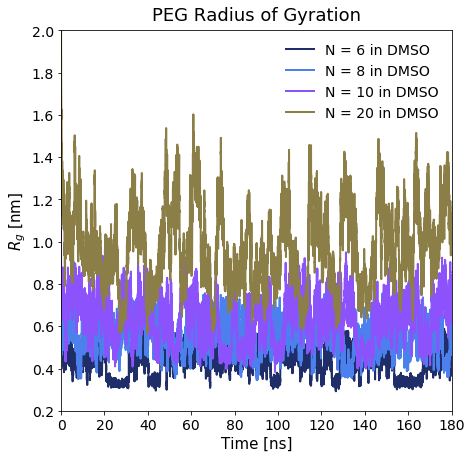

In [147]:
plt.figure(figsize=(7,7))
plt.title(r'PEG Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n6peg_rgens_dmso[0]/10,linewidth=2, color='#1F2E69')
plt.plot(trj_len/100, n8peg_rgens_dmso[0]/10,linewidth=2, color='#4C80ED')
plt.plot(trj_len/100, n10peg_rgens_dmso[0]/10,linewidth=2, color='#8C52FC')
plt.plot(trj_len/100, n20peg_rgens_dmso[0]/10,linewidth=2, color='#8B7F47')
plt.tick_params(labelsize=14)
plt.legend(['N = 6 in DMSO','N = 8 in DMSO','N = 10 in DMSO','N = 20 in DMSO'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Correlation values at each arc length for the whole 180 ns trajectory, N = 20 PEG/dmso

In [148]:
# x values
blen_n20dmso = cor_n20peg_dmso[3]*lb_avg_pn6
#nt_tt[0] = 0
blen_n20dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544,
       16.209568 , 19.4514816, 22.6933952, 25.9353088, 29.1772224,
       32.419136 , 35.6610496, 38.9029632, 42.1448768, 45.3867904,
       48.628704 , 51.8706176, 55.1125312, 58.3544448])

In [149]:
# Error prop. into natural log std deviation
mk_n20p_dmso = cor_n20peg_dmso[1]/cor_n20peg_dmso[0]
mk_n20p_dmso

array([1.89426014e-17, 1.69080022e-02, 5.45907842e-02, 1.19242128e-01,
       1.90666468e-01, 2.55906521e-01, 3.09426342e-01, 3.62270388e-01,
       4.17946392e-01, 4.78722161e-01, 5.50982013e-01, 6.25378268e-01,
       7.08742142e-01, 8.18577522e-01, 9.68697385e-01, 1.12735189e+00,
       1.30433303e+00, 1.47623608e+00, 1.78514071e+00])

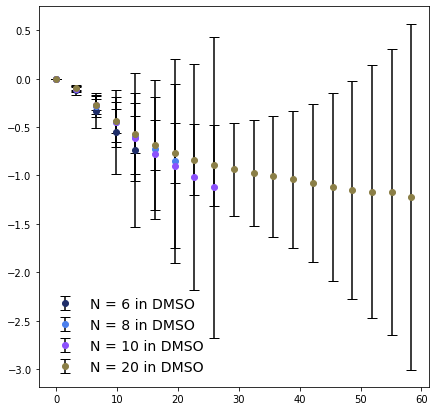

In [150]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_dmso, np.log(cor_n6peg_dmso[0]), yerr=mk_n6p_dmso, color='#1F2E69', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8dmso, np.log(cor_n8peg_dmso[0]), yerr=mk_n8p_dmso, color='#4C80ED', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10dmso, np.log(cor_n10peg_dmso[0]), yerr=mk_n10p_dmso, color='#8C52FC', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n20dmso, np.log(cor_n20peg_dmso[0]), yerr=mk_n20p_dmso, color='#8B7F47', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.legend(['N = 6 in DMSO','N = 8 in DMSO','N = 10 in DMSO','N = 20 in DMSO'], frameon=False, fontsize=14)

In [151]:
# All the points give the best fits for N = 6 peg in water
n20_blkspeg_dmso , n20peg_lpdmso = bavg_pers_cnt(5, peg_n20dmso, n20_peg_dmso, lb_avg_pn6, 5, 3000 , 18000)

3000
6000
Lp [Angstroms]: 24.360254268278428
Error in Lp from fit [Angstroms], 95% CL : 0.21305591430778867
R2 score: 0.9931032834573079
6000
9000
Lp [Angstroms]: 21.492769238261108
Error in Lp from fit [Angstroms], 95% CL : 0.2598127990634099
R2 score: 0.9874401568877104
9000
12000
Lp [Angstroms]: 21.707005124486685
Error in Lp from fit [Angstroms], 95% CL : 0.25433781334677297
R2 score: 0.9881551815611648
12000
15000
Lp [Angstroms]: 24.256415557196032
Error in Lp from fit [Angstroms], 95% CL : 0.2429912354058217
R2 score: 0.9911607410208927
15000
18000
Lp [Angstroms]: 22.831261064594724
Error in Lp from fit [Angstroms], 95% CL : 0.23764917940632213
R2 score: 0.990435684398902


In [152]:
n20_blkspeg_dmso

{'Avg Radius of gyration': array([ 9.91003773,  9.47370962,  9.35779023,  9.6068551 , 10.34102697]),
 'Avg persistence length': array([24.36025427, 21.49276924, 21.70700512, 24.25641556, 22.83126106])}

In [153]:
n20peg_lpdmso

array([[ 2.43602543e+01,  2.14927692e+01,  2.17070051e+01,
         2.42564156e+01,  2.28312611e+01],
       [ 2.13055914e-01,  2.59812799e-01,  2.54337813e-01,
         2.42991235e-01,  2.37649179e-01],
       [-4.10504746e-02, -4.65272757e-02, -4.60680778e-02,
        -4.12262066e-02, -4.37995955e-02],
       [ 2.63794237e-04,  6.47376548e-04,  5.96248931e-04,
         3.49043941e-04,  4.25361737e-04]])

In [154]:
n20peg_lpdmso[2]

array([-0.04105047, -0.04652728, -0.04606808, -0.04122621, -0.0437996 ])

In [155]:
np.mean(n20peg_lpdmso[3])

0.00045636507877836125

In [156]:
blen_dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544])

In [157]:
blen_n20dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544,
       16.209568 , 19.4514816, 22.6933952, 25.9353088, 29.1772224,
       32.419136 , 35.6610496, 38.9029632, 42.1448768, 45.3867904,
       48.628704 , 51.8706176, 55.1125312, 58.3544448])

In [158]:
gg_n20peg_dmso = line_fit(np.mean(n20peg_lpdmso[2]),blen_n20dmso)

In [159]:
gg_n6peg_n20dmso = line_fit(np.mean(n6peg_lpdmso[2]),blen_n20dmso)

In [160]:
gg_n8peg_n20dmso = line_fit(np.mean(n8peg_lpdmso[2]),blen_n20dmso)

In [161]:
gg_n10peg_n20dmso = line_fit(np.mean(n10peg_lpdmso[2]),blen_n20dmso)

In [162]:
gg_n20peg_dmso

array([-0.        , -0.14178291, -0.28356581, -0.42534872, -0.56713163,
       -0.70891453, -0.85069744, -0.99248034, -1.13426325, -1.27604616,
       -1.41782906, -1.55961197, -1.70139488, -1.84317778, -1.98496069,
       -2.1267436 , -2.2685265 , -2.41030941, -2.55209232])

### Block averaged Radius of gyration and persistence length, N = 20 PEG/DMSO

In [163]:
np.mean(n20_blkspeg_dmso["Avg persistence length"])

22.929541050563397

In [164]:
np.std(n20_blkspeg_dmso["Avg persistence length"])

1.2145865596582854

In [165]:
np.mean(n20_blkspeg_dmso["Avg Radius of gyration"])

9.737883930275974

In [166]:
np.std(n20_blkspeg_dmso["Avg Radius of gyration"])

0.3535099165872252

Text(0.5, -4.9, '$N_{PEG}$ = 20: $L_{p}$ = 22.9 $\\AA$ ± 1.21 $\\AA$')

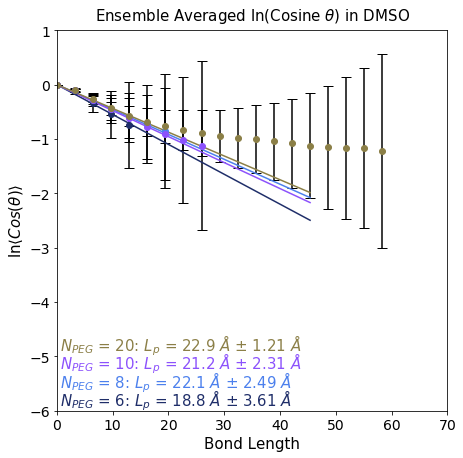

In [173]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_dmso, np.log(cor_n6peg_dmso[0]), yerr=mk_n6p_dmso, color='#1F2E69', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8dmso, np.log(cor_n8peg_dmso[0]), yerr=mk_n8p_dmso, color='#4C80ED', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10dmso, np.log(cor_n10peg_dmso[0]), yerr=mk_n10p_dmso, color='#8C52FC', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n20dmso, np.log(cor_n20peg_dmso[0]), yerr=mk_n20p_dmso, color='#8B7F47', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen_n20dmso[:15], gg_n6peg_n20dmso[:15], color='#1F2E69')
plt.plot(blen_n20dmso[:15], gg_n8peg_n20dmso[:15], color='#4C80ED')
plt.plot(blen_n20dmso[:15], gg_n10peg_n20dmso[:15], color='#8C52FC')
plt.plot(blen_n20dmso[:15], gg_n20peg_dmso[:15], color='#8B7F47')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in DMSO', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.ylim(-6,1)
plt.xlim(0,70)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
#plt.legend([r'$N_{PEG}$ = 6: $L_{p}$ = 18.8 $\AA$ ± 3.60 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(0.5, -5.9,r'$N_{PEG}$ = 6: $L_{p}$ = 18.8 $\AA$ ± 3.61 $\AA$', fontsize=15, color='#1F2E69')
plt.text(0.5, -5.58,r'$N_{PEG}$ = 8: $L_{p}$ = 22.1 $\AA$ ± 2.49 $\AA$', fontsize=15, color='#4C80ED')
plt.text(0.5, -5.23,r'$N_{PEG}$ = 10: $L_{p}$ = 21.2 $\AA$ ± 2.31 $\AA$', fontsize=15, color='#8C52FC')
plt.text(0.5, -4.90,r'$N_{PEG}$ = 20: $L_{p}$ = 22.9 $\AA$ ± 1.21 $\AA$', fontsize=15, color='#8B7F47')

In [174]:
rgpeg_olig_dmso[r"$R_{g}$ [Angstrom] N = 20 PEG DMSO "] = n20_blkspeg_dmso["Avg Radius of gyration"]
rgpeg_olig_dmso

,$R_{g}$ [Angstrom] N = 6 PEG DMSO,$R_{g}$ [Angstrom] N = 8 PEG DMSO,$R_{g}$ [Angstrom] N = 10 PEG DMSO,$R_{g}$ [Angstrom] N = 20 PEG DMSO
0,4.448959,5.719623,6.413897,9.910038
1,4.748702,5.761057,5.740915,9.473710
2,4.534691,5.672010,6.420186,9.357790
3,4.531934,5.296935,6.206639,9.606855
4,4.163879,5.451634,6.600141,10.341027


In [175]:
pers_pegt_dmso[r"$L_{p}$ [Angstrom] N = 20 PEG DMSO "] = n20_blkspeg_dmso["Avg persistence length"]
pers_pegt_dmso

,$L_{p}$ [Angstrom] N = 6 PEG DMSO,$L_{p}$ [Angstrom] N = 8 PEG DMSO,$L_{p}$ [Angstrom] N = 10 PEG DMSO,$L_{p}$ [Angstrom] N = 20 PEG DMSO
0,16.809451,24.031716,22.492805,24.360254
1,25.078842,24.516849,17.209328,21.492769
2,18.201036,23.768712,21.636686,21.707005
3,19.792809,18.256586,20.518808,24.256416
4,14.283993,20.108643,24.107676,22.831261


### N = 30 PEG/DMSO 

In [178]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n30_peg_dmso = mda.Universe("n30peg_dmso/n30pegonly_dmso.pdb", "n30peg_dmso/nodmso_n30peg.xtc")

In [179]:
n30_peg_dmso.trajectory

<XTCReader n30peg_dmso/nodmso_n30peg.xtc with 18001 frames of 213 atoms>

In [180]:
len(n30_peg_dmso.trajectory)

18001

In [181]:
#Select the polymer heavy atoms 
peg_n30dmso = n30_peg_dmso.select_atoms("resname sPEG PEG tPEG and not type H")

In [182]:
crv_n30peg_dmso = pers_length(peg_n30dmso,30)
crv_n30peg_dmso

array([[ 1.00000000e+00,  9.36606509e-01,  8.50601520e-01,
         8.05799441e-01,  7.89863431e-01,  7.73644056e-01,
         7.50802361e-01,  7.40923619e-01,  7.41553797e-01,
         7.32392799e-01,  7.41844030e-01,  7.13691954e-01,
         6.96576197e-01,  6.77030978e-01,  6.59215136e-01,
         6.41332183e-01,  6.12871887e-01,  5.85829860e-01,
         5.67631204e-01,  5.48032715e-01,  5.15212789e-01,
         4.67398438e-01,  4.17144054e-01,  3.72076460e-01,
         3.26342519e-01,  1.92443093e-01,  7.84355218e-02,
        -1.49950123e-01, -4.16079049e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00,
         3.00000000e+00,  4.00000000e+00,  5.00000000e+00,
         6.00000000e+00,  7.00000000e+00,  8.00000000e+00,
         9.00000000e+00,  1.00000000e+01,  1.10000000e+01,
         1.20000000e+01,  1.30000000e+01,  1.40000000e+01,
         1.50000000e+01,  1.60000000e+01,  1.70000000e+01,
         1.80000000e+01,  1.90000000e+01,  2.00000000e+01,
         2.10

In [183]:
com_bond_n30dmso = np.zeros(shape=(1,18000))
count = 0
for ts in n30_peg_dmso.trajectory[0:18000]:
    n30_mon1_dmso = n30_peg_dmso.select_atoms("resid 1")
    n30_mon2_dmso = n30_peg_dmso.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n30_mon1_dmso.center_of_mass(), n30_mon2_dmso.center_of_mass(), 
                                                   box=n30_peg_dmso.trajectory.ts.dimensions)
    com_bond_n30dmso[0, count] = oo_len
    count += 1
    

In [184]:
com_bond

array([[3.53350002, 3.23345886, 3.20921526, ..., 3.25338305, 3.09876112,
        2.93677543]])

In [185]:
lb_avg_pn6

3.2419135998493824

In [186]:
np.std(com_bond)

0.18863018935460654

In [187]:
np.mean(com_bond_n30dmso)

3.222676166802996

In [188]:
np.std(com_bond_n30dmso)

0.20082673751593924

### Radius of Gyration vs. time N = 30 PEG/dmso

In [189]:
n30peg_rgens_dmso, cor_n30peg_dmso, N30peg_cos_dmso, rgdmso_n30peg = get_rg_pers_poly(peg_n30dmso, n30_peg_dmso, 0, 18000)

In [190]:
n30peg_rgens_dmso[0].shape

(18000,)

In [191]:
cor_n30peg_dmso[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28.])

In [192]:
N30peg_cos_dmso

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.93660651,  0.92594169,  0.92461647, ...,  0.90421473,
         0.90348714,  0.91788901],
       [ 0.85060152,  0.84351967,  0.83502569, ...,  0.75481655,
         0.7621064 ,  0.78119975],
       ...,
       [ 0.07843552,  0.19720771,  0.22223418, ...,  0.743836  ,
         0.83050479,  0.8440785 ],
       [-0.14995012, -0.07947395, -0.07491421, ...,  0.70070551,
         0.88150512,  0.84100393],
       [-0.41607905, -0.71607782, -0.74136293, ...,  0.6657293 ,
         0.87120916,  0.79111139]])

In [193]:
rgdmso_n30peg

12.440932215168166

In [194]:
np.std(n30peg_rgens_dmso)

2.5447670166772176

(0.2, 3)

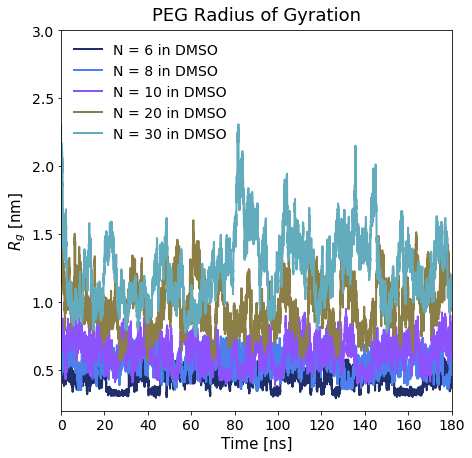

In [218]:
plt.figure(figsize=(7,7))
plt.title(r'PEG Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n6peg_rgens_dmso[0]/10,linewidth=2, color='#1F2E69')
plt.plot(trj_len/100, n8peg_rgens_dmso[0]/10,linewidth=2, color='#4C80ED')
plt.plot(trj_len/100, n10peg_rgens_dmso[0]/10,linewidth=2, color='#8C52FC')
plt.plot(trj_len/100, n20peg_rgens_dmso[0]/10,linewidth=2, color='#8B7F47')
plt.plot(trj_len/100, n30peg_rgens_dmso[0]/10,linewidth=2, color='#63ACBE')
plt.tick_params(labelsize=14)
plt.legend(['N = 6 in DMSO','N = 8 in DMSO','N = 10 in DMSO','N = 20 in DMSO','N = 30 in DMSO'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,3)

#### Correlation values at each arc length for the whole 180 ns trajectory, N = 30 PEG/dmso

In [196]:
# x values
blen_n30dmso = cor_n30peg_dmso[3]*lb_avg_pn6
#nt_tt[0] = 0
blen_n30dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544,
       16.209568 , 19.4514816, 22.6933952, 25.9353088, 29.1772224,
       32.419136 , 35.6610496, 38.9029632, 42.1448768, 45.3867904,
       48.628704 , 51.8706176, 55.1125312, 58.3544448, 61.5963584,
       64.838272 , 68.0801856, 71.3220992, 74.5640128, 77.8059264,
       81.04784  , 84.2897536, 87.5316672, 90.7735808])

In [197]:
# Error prop. into natural log std deviation
mk_n30p_dmso = cor_n30peg_dmso[1]/cor_n30peg_dmso[0]
mk_n30p_dmso

array([2.48253415e-18, 1.35114145e-02, 4.33491326e-02, 9.07893766e-02,
       1.42919320e-01, 1.89154637e-01, 2.32028277e-01, 2.73172231e-01,
       3.07970837e-01, 3.41859728e-01, 3.74075097e-01, 4.05479501e-01,
       4.45338385e-01, 4.95148638e-01, 5.47702578e-01, 6.08458246e-01,
       6.83554088e-01, 7.67625571e-01, 8.43765101e-01, 9.02795874e-01,
       9.43004188e-01, 9.85454710e-01, 1.05307057e+00, 1.15237198e+00,
       1.26437473e+00, 1.42359880e+00, 1.63317094e+00, 1.87123726e+00,
       2.28307196e+00])

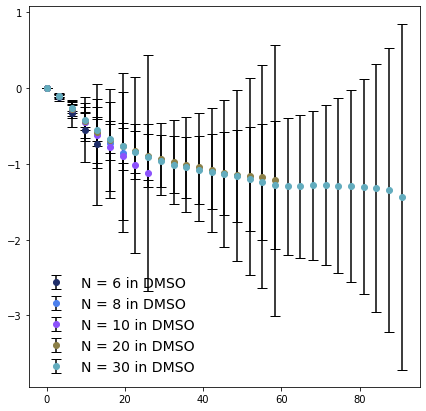

In [198]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_dmso, np.log(cor_n6peg_dmso[0]), yerr=mk_n6p_dmso, color='#1F2E69', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8dmso, np.log(cor_n8peg_dmso[0]), yerr=mk_n8p_dmso, color='#4C80ED', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10dmso, np.log(cor_n10peg_dmso[0]), yerr=mk_n10p_dmso, color='#8C52FC', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n20dmso, np.log(cor_n20peg_dmso[0]), yerr=mk_n20p_dmso, color='#8B7F47', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n30dmso, np.log(cor_n30peg_dmso[0]), yerr=mk_n30p_dmso, color='#63ACBE', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.legend(['N = 6 in DMSO','N = 8 in DMSO','N = 10 in DMSO','N = 20 in DMSO','N = 30 in DMSO'], frameon=False, fontsize=14)

In [199]:
# All the points give the best fits for N = 6 peg in water
n30_blkspeg_dmso , n30peg_lpdmso = bavg_pers_cnt(5, peg_n30dmso, n30_peg_dmso, lb_avg_pn6, 5, 3000 , 18000)

3000
6000
Lp [Angstroms]: 23.86345447339396
Error in Lp from fit [Angstroms], 95% CL : 0.1166535192311226
R2 score: 0.9912928583708327
6000
9000
Lp [Angstroms]: 23.753121899827295
Error in Lp from fit [Angstroms], 95% CL : 0.11586847222566812
R2 score: 0.991309747083878
9000
12000
Lp [Angstroms]: 25.07552576394827
Error in Lp from fit [Angstroms], 95% CL : 0.10471197544385624
R2 score: 0.9934684236348461
12000
15000
Lp [Angstroms]: 25.95801812439543
Error in Lp from fit [Angstroms], 95% CL : 0.0997631986981003
R2 score: 0.9944366777128748
15000
18000
Lp [Angstroms]: 22.297741821168206
Error in Lp from fit [Angstroms], 95% CL : 0.12358115359164186
R2 score: 0.9889928125471411


In [200]:
n30_blkspeg_dmso

{'Avg Radius of gyration': array([10.84031301, 13.29950051, 13.00391926, 13.76137509, 12.0814456 ]),
 'Avg persistence length': array([23.86345447, 23.7531219 , 25.07552576, 25.95801812, 22.29774182])}

In [201]:
n30peg_lpdmso

array([[ 2.38634545e+01,  2.37531219e+01,  2.50755258e+01,
         2.59580181e+01,  2.22977418e+01],
       [ 1.16653519e-01,  1.15868472e-01,  1.04711975e-01,
         9.97631987e-02,  1.23581154e-01],
       [-4.19050813e-02, -4.20997292e-02, -3.98795227e-02,
        -3.85237423e-02, -4.48475908e-02],
       [ 3.55057673e-04,  3.56848793e-04,  2.34654548e-04,
         1.85477429e-04,  5.22754068e-04]])

In [202]:
n30peg_lpdmso[2]

array([-0.04190508, -0.04209973, -0.03987952, -0.03852374, -0.04484759])

In [203]:
np.mean(n30peg_lpdmso[3])

0.000330958502245751

In [204]:
blen_dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544])

In [205]:
blen_n30dmso

array([ 0.       ,  3.2419136,  6.4838272,  9.7257408, 12.9676544,
       16.209568 , 19.4514816, 22.6933952, 25.9353088, 29.1772224,
       32.419136 , 35.6610496, 38.9029632, 42.1448768, 45.3867904,
       48.628704 , 51.8706176, 55.1125312, 58.3544448, 61.5963584,
       64.838272 , 68.0801856, 71.3220992, 74.5640128, 77.8059264,
       81.04784  , 84.2897536, 87.5316672, 90.7735808])

In [206]:
gg_n30peg_dmso = line_fit(np.mean(n30peg_lpdmso[2]),blen_n30dmso)

In [207]:
gg_n6peg_n30dmso = line_fit(np.mean(n6peg_lpdmso[2]),blen_n30dmso)

In [208]:
gg_n8peg_n30dmso = line_fit(np.mean(n8peg_lpdmso[2]),blen_n30dmso)

In [209]:
gg_n10peg_n30dmso = line_fit(np.mean(n10peg_lpdmso[2]),blen_n30dmso)

In [210]:
gg_n20peg_n30dmso = line_fit(np.mean(n20peg_lpdmso[2]),blen_n30dmso)

In [211]:
gg_n30peg_dmso

array([-0.        , -0.13438099, -0.26876199, -0.40314298, -0.53752397,
       -0.67190496, -0.80628596, -0.94066695, -1.07504794, -1.20942893,
       -1.34380993, -1.47819092, -1.61257191, -1.7469529 , -1.8813339 ,
       -2.01571489, -2.15009588, -2.28447687, -2.41885787, -2.55323886,
       -2.68761985, -2.82200085, -2.95638184, -3.09076283, -3.22514382,
       -3.35952482, -3.49390581, -3.6282868 , -3.76266779])

### Block averaged Radius of gyration and persistence length, N = 30 PEG/DMSO

In [212]:
np.mean(n30_blkspeg_dmso["Avg persistence length"])

24.189572416546632

In [213]:
np.std(n30_blkspeg_dmso["Avg persistence length"])

1.248052765181152

In [214]:
np.mean(n30_blkspeg_dmso["Avg Radius of gyration"])

12.597310693594403

In [215]:
np.std(n30_blkspeg_dmso["Avg Radius of gyration"])

1.0360120325355755

Text(0.5, -4.5, '$N_{PEG}$ = 30: $L_{p}$ = 24.2 $\\AA$ ± 1.25 $\\AA$')

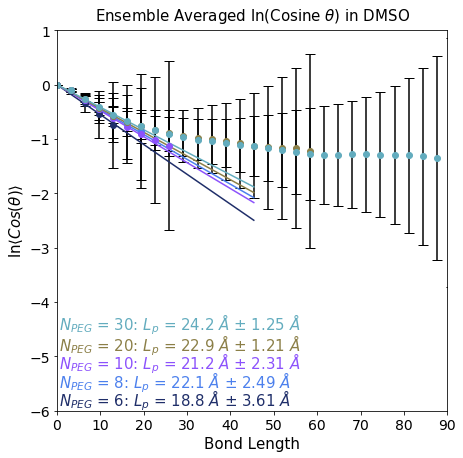

In [220]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_dmso, np.log(cor_n6peg_dmso[0]), yerr=mk_n6p_dmso, color='#1F2E69', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8dmso, np.log(cor_n8peg_dmso[0]), yerr=mk_n8p_dmso, color='#4C80ED', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10dmso, np.log(cor_n10peg_dmso[0]), yerr=mk_n10p_dmso, color='#8C52FC', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n20dmso, np.log(cor_n20peg_dmso[0]), yerr=mk_n20p_dmso, color='#8B7F47', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n30dmso, np.log(cor_n30peg_dmso[0]), yerr=mk_n30p_dmso, color='#63ACBE', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen_n20dmso[:15], gg_n6peg_n30dmso[:15], color='#1F2E69')
plt.plot(blen_n20dmso[:15], gg_n8peg_n30dmso[:15], color='#4C80ED')
plt.plot(blen_n20dmso[:15], gg_n10peg_n30dmso[:15], color='#8C52FC')
plt.plot(blen_n20dmso[:15], gg_n20peg_n30dmso[:15], color='#8B7F47')
plt.plot(blen_n30dmso[:15], gg_n30peg_dmso[:15], color='#63ACBE')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in DMSO', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.ylim(-6,1)
plt.xlim(0,90)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
#plt.legend([r'$N_{PEG}$ = 6: $L_{p}$ = 18.8 $\AA$ ± 3.60 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(0.5, -5.9,r'$N_{PEG}$ = 6: $L_{p}$ = 18.8 $\AA$ ± 3.61 $\AA$', fontsize=15, color='#1F2E69')
plt.text(0.5, -5.58,r'$N_{PEG}$ = 8: $L_{p}$ = 22.1 $\AA$ ± 2.49 $\AA$', fontsize=15, color='#4C80ED')
plt.text(0.5, -5.23,r'$N_{PEG}$ = 10: $L_{p}$ = 21.2 $\AA$ ± 2.31 $\AA$', fontsize=15, color='#8C52FC')
plt.text(0.5, -4.90,r'$N_{PEG}$ = 20: $L_{p}$ = 22.9 $\AA$ ± 1.21 $\AA$', fontsize=15, color='#8B7F47')
plt.text(0.5, -4.50,r'$N_{PEG}$ = 30: $L_{p}$ = 24.2 $\AA$ ± 1.25 $\AA$', fontsize=15, color='#63ACBE')

In [216]:
rgpeg_olig_dmso[r"$R_{g}$ [Angstrom] N = 30 PEG DMSO "] = n30_blkspeg_dmso["Avg Radius of gyration"]
rgpeg_olig_dmso

,$R_{g}$ [Angstrom] N = 6 PEG DMSO,$R_{g}$ [Angstrom] N = 8 PEG DMSO,$R_{g}$ [Angstrom] N = 10 PEG DMSO,$R_{g}$ [Angstrom] N = 20 PEG DMSO,$R_{g}$ [Angstrom] N = 30 PEG DMSO
0,4.448959,5.719623,6.413897,9.910038,10.840313
1,4.748702,5.761057,5.740915,9.473710,13.299501
2,4.534691,5.672010,6.420186,9.357790,13.003919
3,4.531934,5.296935,6.206639,9.606855,13.761375
4,4.163879,5.451634,6.600141,10.341027,12.081446


In [217]:
pers_pegt_dmso[r"$L_{p}$ [Angstrom] N = 30 PEG DMSO "] = n30_blkspeg_dmso["Avg persistence length"]
pers_pegt_dmso

,$L_{p}$ [Angstrom] N = 6 PEG DMSO,$L_{p}$ [Angstrom] N = 8 PEG DMSO,$L_{p}$ [Angstrom] N = 10 PEG DMSO,$L_{p}$ [Angstrom] N = 20 PEG DMSO,$L_{p}$ [Angstrom] N = 30 PEG DMSO
0,16.809451,24.031716,22.492805,24.360254,23.863454
1,25.078842,24.516849,17.209328,21.492769,23.753122
2,18.201036,23.768712,21.636686,21.707005,25.075526
3,19.792809,18.256586,20.518808,24.256416,25.958018
4,14.283993,20.108643,24.107676,22.831261,22.297742


In [223]:
rgpeg_olig_dmso.to_pickle("PEG_dmso_Rg.pkl")

In [224]:
pers_pegt_dmso.to_pickle("PEG_dmso_Lp.pkl")

### Fluory Exponent, PEG/DMSO systems 

In [225]:
n_peg = np.array([6,8,10,20,30])
rg_npeg_dmso = np.array([np.mean(n6_blkspeg_dmso["Avg Radius of gyration"])
                    ,np.mean(n8_blkspeg_dmso["Avg Radius of gyration"]),np.mean(n10_blkspeg_dmso["Avg Radius of gyration"])
                    ,np.mean(n20_blkspeg_dmso["Avg Radius of gyration"]),np.mean(n30_blkspeg_dmso["Avg Radius of gyration"])])

In [226]:
rg_npeg_dmso

array([ 4.485633  ,  5.58025202,  6.27635561,  9.73788393, 12.59731069])

In [227]:
rgdmso_npeg_std = np.array([np.std(np.log10(n6_blkspeg_dmso["Avg Radius of gyration"]))
                    ,np.std(np.log10(n8_blkspeg_dmso["Avg Radius of gyration"]))
                        ,np.std(np.log10(n10_blkspeg_dmso["Avg Radius of gyration"]))
                    ,np.std(np.log10(n20_blkspeg_dmso["Avg Radius of gyration"]))
                        ,np.std(np.log10(n30_blkspeg_dmso["Avg Radius of gyration"]))])
rgdmso_npeg_std

array([0.01850255, 0.01393642, 0.02090327, 0.01558821, 0.03685753])

In [228]:
n_peg

array([ 6,  8, 10, 20, 30])

In [ ]:
np.log10(rg_npeg_dmso)

In [ ]:
np.log10(n_peg)

In [229]:
# From fitting all points, I get best fit 
from sklearn.linear_model import LinearRegression
model_vdmso = LinearRegression(fit_intercept=True)
model_vdmso.fit(np.log10(n_peg).reshape(-1,1), np.log10(rg_npeg_dmso))
# Slope here is in nanometers
print("Model slope:    ", model_vdmso.coef_[0])
print("Model intercept:", model_vdmso.intercept_)

Model slope:     0.6330716745864243
Model intercept: 0.16574815673194487


In [230]:
gg_dmso = model_vdmso.predict(np.log10(n_peg.reshape(-1,1)))
gg_dmso

array([0.65837367, 0.73746885, 0.79881983, 0.98939339, 1.10087178])

In [231]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(np.log10(rg_npeg_dmso), gg_dmso))
print("R2 score:", sklearn.metrics.r2_score(np.log10(rg_npeg_dmso), gg_dmso))

Mean Std Error: 2.5943574581609202e-05
R2 score: 0.9990338036343539


In [232]:
# Residuals between the true y data and model y data 
resid_vdmso = np.log10(rg_npeg_dmso) - gg_dmso
resid_vdmso

array([-0.00654993,  0.00918497, -0.00111229, -0.0009288 , -0.00059394])

In [233]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_ttace = np.log10(n_peg)
nt_ttace -= np.mean(nt_ttace)
nhui_ace = nt_ttace**2
np.sum(nhui_ace)

0.334663876760361

In [234]:
# t-value with 95 % confidence intervals 
scipy.stats.t.ppf(0.975, 4)

2.7764451051977987

In [236]:
# How to calculate 95% confidence interval for the slope 
flc_vdmso = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_vdmso**2)/len(resid_vdmso))/(np.sum(nhui_ace)))
flc_vdmso

0.02444553686226127

Text(1.1, 0.75, '$v_{DMSO}$ = 0.63 ± 0.02')

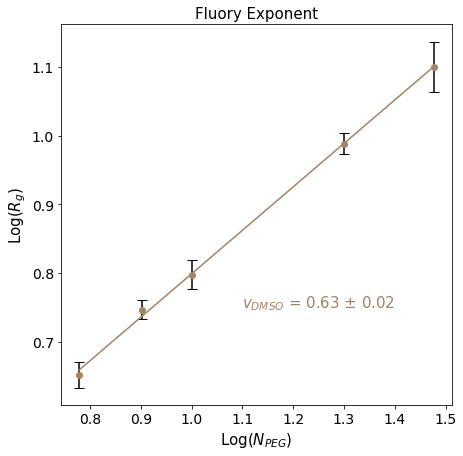

In [238]:
plt.figure(figsize=(7,7))
plt.errorbar(np.log10(n_peg), np.log10(rg_npeg_dmso), yerr=rgdmso_npeg_std, color='#A58262', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(np.log10(n_peg), gg_dmso, color='#A58262')
plt.title(r'Fluory Exponent', fontsize=15)
plt.xlabel(r'Log($N_{PEG}$)', fontsize=15)
plt.ylabel(r'Log($R_{g}$)', fontsize=15)
plt.tick_params(labelsize=14)
plt.text(1.1, 0.75, r'$v_{DMSO}$ = 0.63 ± 0.02', fontsize=15, color='#A58262')